**Data Fields**
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

In [4]:
# libraries
!pip install langdetect
# ===============================
# 1. Системні та налаштування
# ===============================
import os
import gc
import time
import datetime
import random
import warnings
from functools import partial
from math import sqrt
from collections import Counter

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ===============================
# 2. Робота з даними
# ===============================
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# ===============================
# 3. Візуалізація
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from PIL import Image

py.init_notebook_mode(connected=True)
plt.style.use('ggplot')
%matplotlib inline

# ===============================
# 4. Machine Learning бібліотеки
# ===============================
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    mean_squared_error, 
    roc_auc_score, 
    cohen_kappa_score, 
    confusion_matrix as sk_cmatrix
)

# ===============================
# 5. NLP
# ===============================
from nltk.tokenize import TweetTokenizer
import langdetect

# ===============================
# 6. Інтерпретація моделей
# ===============================
import eli5
from IPython.display import display

# ===============================
# 7. Корисні функції
# ===============================
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

E0000 00:00:1756132568.376678     396 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756132568.386416     396 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

Отримуємо дані для датасету

In [5]:
breeds = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/breed_labels.csv')
colors = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/color_labels.csv')
states = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/state_labels.csv')

train = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/test.csv')
sub = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/sample_submission.csv')
submit = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/test.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

In [6]:
print(os.listdir("../input/petfinder-adoption-prediction/"))

['state_labels.csv', 'train_metadata', 'color_labels.csv', 'StateLabels.csv', 'train_images', 'test_metadata', 'PetFinder-BreedLabels.csv', 'BreedLabels.csv', 'train_sentiment', 'ColorLabels.csv', 'test_sentiment', 'PetFinder-ColorLabels.csv', 'PetFinder-StateLabels.csv', 'test', 'train', 'breed_labels.csv', 'test_images']


In [7]:
train.drop('Description', axis=1).head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

       PetID  PhotoAmt  AdoptionSpeed dataset_type  
0  86e1089a3       1.0              2        train  
1  6296e909a       2.0              0        train  
2  3422e4906       7.0              3        train  
3  5842f1ff5       8.0              2        train  
4  850a43f90       3.0              2        train

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [9]:
# Перевіримо наявність пропусків
train.isnull().sum()

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dataset_type        0
dtype: int64

Text(0.5, 1.0, 'Розподіл AdoptionSpeed')

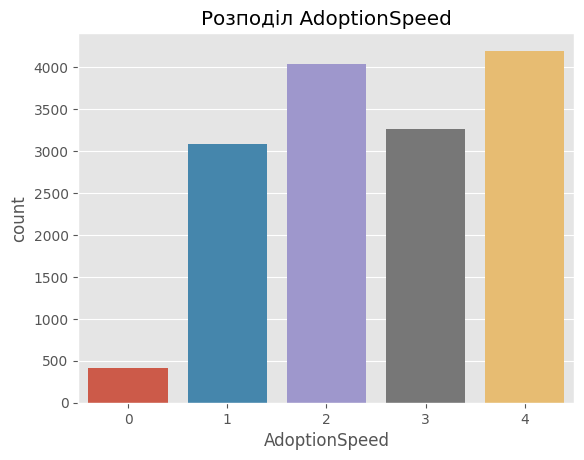

In [10]:
sns.countplot(data=train, x='AdoptionSpeed')
plt.title('Розподіл AdoptionSpeed')

1. Маємо розуміння, що за 7 діб тварини практично не знаходять домівку. Ці дані ми приймаємо як факт, без зміни.
2. Створюємо бінарну ознаку: HasName (чи є ім'я чи не має).
3. Заповнюємо порожні значення спеціальним тегом, наприклад "No description".

In [11]:
all_data['HasName'] = all_data['Name'].notnull().astype(int)
all_data['Description'] = all_data['Description'].fillna("No description")

Попередня обробка тексту для 'Description'

In [12]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # залишаємо лише букви
    return text

train['clean_description'] = train['Description'].apply(clean_text)
test['clean_description'] = test['Description'].apply(clean_text)


Обробка зображень (опціонально на цьому етапі)
У повній моделі зображення можна буде обробити через CNN (наприклад, ResNet з torchvision.models).

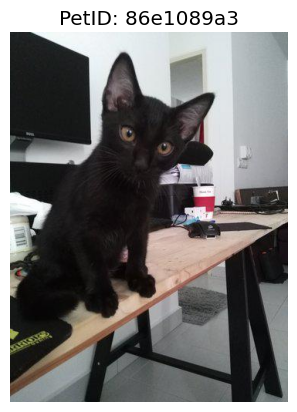

In [13]:
# приклад візуалізації зображення
example_pet_id = train['PetID'].iloc[0]
image_path = f"/kaggle/input/petfinder-adoption-prediction/train_images/{example_pet_id}-1.jpg"

img = Image.open(image_path)
plt.imshow(img)
plt.title(f"PetID: {example_pet_id}")
plt.axis('off')
plt.show()

Проводимо перетворення тексту у вектори (TF-IDF / Transformers)

In [14]:
tfidf = TfidfVectorizer(max_features=500)
tfidf_train = tfidf.fit_transform(train['clean_description'])
tfidf_test = tfidf.transform(test['clean_description'])


не використовуємо: 
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

Об'єднання табличних та текстових фіч

In [15]:
from scipy.sparse import hstack

# Вибираємо фічі 
features = ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt'] 
X = train[features] 
y = train['AdoptionSpeed'] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_combined = hstack([X_train, tfidf_train[:X_train.shape[0]]])
X_combined_val = hstack([X_val, tfidf_train[X_train.shape[0]:]])

model = lgb.LGBMClassifier()
model.fit(X_combined, y_train)

y_pred = model.predict(X_combined_val)
score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
print("Kappa with text:", score)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75976
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 516
[LightGBM] [Info] Start training from score -3.630110
[LightGBM] [Info] Start training from score -1.583026
[LightGBM] [Info] Start training from score -1.311615
[LightGBM] [Info] Start training from score -1.521996
[LightGBM] [Info] Start training from score -1.271276
Kappa with text: 0.3170647198549391


 ResNet/VGG для зображень

In [16]:
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
from scipy.sparse import hstack

# ==========================
# 1. Ініціалізація ResNet50
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
resnet.eval()
resnet = resnet.to(device)

# Беремо всі шари, крім останнього fully-connected
resnet_features = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet_features = resnet_features.to(device)

# Трансформації для зображень
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ==========================
# 2. Функція для витягання фіч
# ==========================
def extract_resnet_features(df, image_folder):
    features_list = []
    
    for pet_id in tqdm(df['PetID'], desc="Extracting ResNet features"):
        image_path = f"{image_folder}/{pet_id}-1.jpg"  # беремо тільки перше зображення
        try:
            img = Image.open(image_path).convert('RGB')
            img = transform(img).unsqueeze(0).to(device)  # додаємо batch dimension
            with torch.no_grad():
                feat = resnet_features(img)
                feat = feat.view(feat.size(0), -1)  # робимо вектор
                features_list.append(feat.cpu().numpy()[0])
        except FileNotFoundError:
            # якщо зображення відсутнє, заповнюємо нулями
            features_list.append(np.zeros(2048, dtype=np.float32))
    
    return np.array(features_list)

# ==========================
# 3. Витягуємо фічі для train і test
# ==========================
train_image_folder = '/kaggle/input/petfinder-adoption-prediction/train_images'
test_image_folder = '/kaggle/input/petfinder-adoption-prediction/test_images'

resnet_train_features = extract_resnet_features(train, train_image_folder)
resnet_test_features = extract_resnet_features(test, test_image_folder)



Extracting ResNet features: 100%|██████████| 3972/3972 [08:49<00:00,  7.51it/s]


Регулярна перевірка метрики

In [17]:
from sklearn.metrics import cohen_kappa_score

def kappa_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


Побудова «портрету» тварини, яка має найвищі шанси на всиновлення

X_train shape: (11994, 2067)
X_val shape: (2999, 2067)
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.861597
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.026684
[LightGBM] [Debug] init for col-wise cost 0.000995 seconds, init for row-wise cost 0.420775 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.682311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522652
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 2067
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from sco

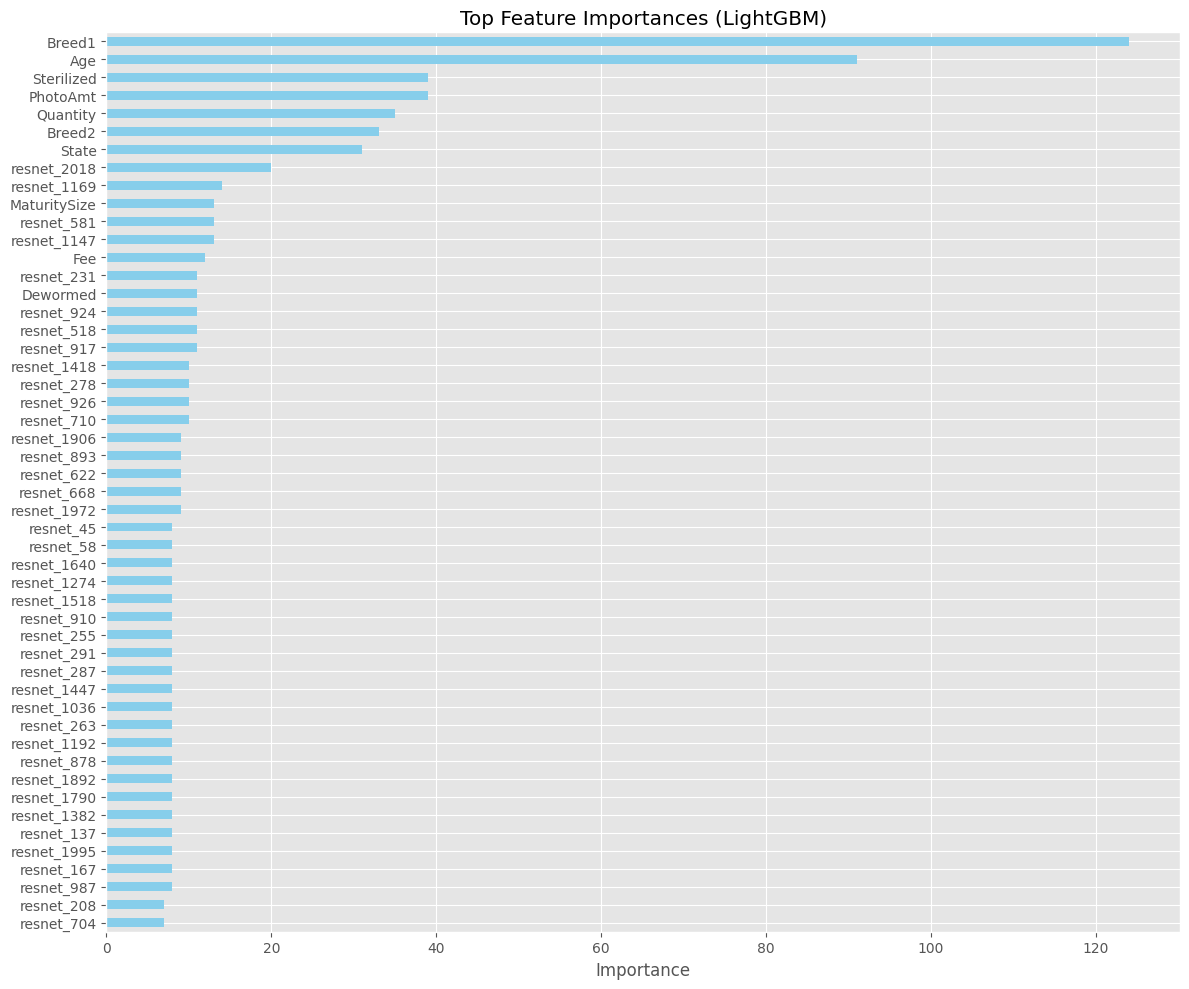

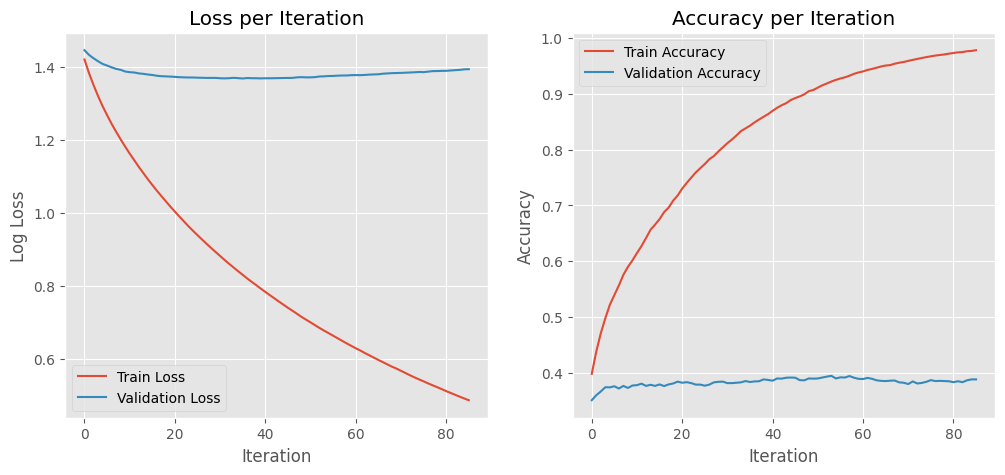

       PetID  AdoptionSpeed
0  e2dfc2935            4.0
1  f153b465f            2.0
2  3c90f3f54            1.0
3  e02abc8a3            4.0
4  09f0df7d1            4.0
5  0487529d4            2.0
6  bae7c4b1c            4.0
7  548bcf206            2.0
8  0f82cea1e            4.0
9  a3787f15e            4.0
AdoptionSpeed
4.0    1646
2.0    1247
1.0     687
3.0     390
0.0       2
Name: count, dtype: int64


In [18]:
# Розділимо тварин на 5 класів: швидко всиновлені (0) + інші (1–4)

import lightgbm as lgb
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping

# ==============================
# 1. Вибір базових ознак
# ==============================
features = [
    'Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
    'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'HasName'
]

train_data = all_data[all_data['dataset_type'] == 'train']
X_tab = train_data[features]
y = train_data['AdoptionSpeed']  # без NaN

categorical_features = [
    'Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
    'Sterilized', 'Health', 'State', 'HasName'
]

# ==============================
# 2. Train/Validation Split
# ==============================
train_idx, val_idx = train_test_split(
    np.arange(len(X_tab)), test_size=0.2, random_state=42, stratify=y
)

# tabular → csr_matrix
X_tab_train = csr_matrix(X_tab.iloc[train_idx].values)
X_tab_val   = csr_matrix(X_tab.iloc[val_idx].values)

y_train = y.iloc[train_idx]
y_val   = y.iloc[val_idx]

# resnet
resnet_train_split = csr_matrix(resnet_train_features[train_idx, :])
resnet_val_split   = csr_matrix(resnet_train_features[val_idx, :])

# tfidf (якщо є)
# tfidf_train_split = tfidf_all[train_idx, :]
# tfidf_val_split   = tfidf_all[val_idx, :]

# ==============================
# 3. Комбінуємо табличні + resnet 
# ==============================
X_train = hstack([X_tab_train, resnet_train_split]) 
X_val   = hstack([X_tab_val, resnet_val_split])     

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# ==============================
# 4. LightGBM з early stopping
# ==============================
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    random_state=42,
    n_estimators=1000,
    verbose=10
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=['multi_logloss', 'multi_error'],
    categorical_feature=[features.index(col) for col in categorical_features],
    callbacks=[early_stopping(stopping_rounds=50)]
)

evals_result = model.evals_result_

# ==============================
# 5. Передбачення на validation
# ==============================
y_pred_val = model.predict(X_val)
score = cohen_kappa_score(y_val, y_pred_val, weights='quadratic')
print("Quadratic Kappa на validation:", score)

# ==============================
# 6. Візуалізація важливості ознак
# ==============================
# 6.1. Індекси для всіх ознак
# ==============================
tab_features = features  # табличні 19
resnet_features_names = [f"resnet_{i}" for i in range(resnet_train_features.shape[1])]
all_feature_names = tab_features + resnet_features_names  

# ==============================
# 6.2. Візуалізація важливості ознак
# ==============================
importances = pd.Series(model.feature_importances_, index=all_feature_names).sort_values(ascending=True)

plt.figure(figsize=(12,10))
importances[-50:].plot(kind='barh', color='skyblue')  # топ-50 для зручності
plt.title('Top Feature Importances (LightGBM)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# ==============================
# 6.3. Loss та Accuracy
# ==============================
train_loss = evals_result['training']['multi_logloss']
val_loss = evals_result['valid_1']['multi_logloss']

train_acc = [1 - x for x in evals_result['training']['multi_error']]
val_acc = [1 - x for x in evals_result['valid_1']['multi_error']]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Loss per Iteration')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per Iteration')
plt.legend()

plt.show()

# ==============================
# 6.4. Передбачення на тестові дані
# ==============================
# Sparse матриця для тесту: табличні + ResNet (+ TF-IDF)
X_tab_test = csr_matrix(all_data[all_data['dataset_type']=='test'][tab_features].values)
resnet_test_sparse = csr_matrix(resnet_test_features)
# tfidf_test_sparse = tfidf_test  # якщо використовуєш

X_test_combined = hstack([X_tab_test, resnet_test_sparse])

y_test_pred = model.predict(X_test_combined)

submission = pd.DataFrame({
    "PetID": all_data[all_data['dataset_type']=='test']['PetID'].values,
    "AdoptionSpeed": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print(submission.head(10))
print(submission['AdoptionSpeed'].value_counts())

In [19]:
# Вибираємо тварин, які були всиновлені найшвидше
quick = all_data[all_data['AdoptionSpeed'] == 0]

# Для числових фіч — середнє або мода
ideal_pet = {}
for col in features:
    if all_data[col].dtype == 'object':
        ideal_pet[col] = quick[col].mode()[0]
    else:
        ideal_pet[col] = int(quick[col].mode()[0])  # або .mean().round()

print("Ідеальні характеристики тварини для швидкого всиновлення:\n")
for key, value in ideal_pet.items():
    print(f"{key}: {value}")

Ідеальні характеристики тварини для швидкого всиновлення:

Type: 2
Age: 2
Breed1: 266
Breed2: 0
Gender: 2
Color1: 1
Color2: 0
MaturitySize: 2
FurLength: 1
Vaccinated: 2
Dewormed: 1
Sterilized: 2
Health: 1
Quantity: 1
Fee: 0
State: 41326
VideoAmt: 0
PhotoAmt: 2
HasName: 1


Знаходимо моду фіч серед швидко усиновлених

In [20]:
quick = all_data[all_data['AdoptionSpeed'] == 0]

# Ознаки для точного фільтрування
important_cols = ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'FurLength',
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'HasName']

# Знаходимо модальні значення для кожної ознаки
ideal_profile = {}
for col in important_cols:
    ideal_profile[col] = quick[col].mode()[0]

# Фільтруємо тварин, які точно збігаються з профілем
matched = quick.copy()
for col, value in ideal_profile.items():
    matched = matched[matched[col] == value]

print(f"Знайдено {len(matched)} тварин, які ідеально відповідають типажу.")


Знайдено 1 тварин, які ідеально відповідають типажу.


Показуємо фотографію

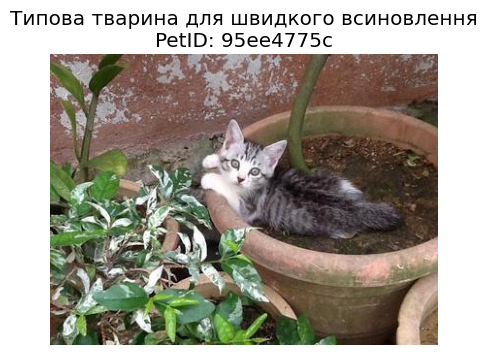

In [21]:
from PIL import Image

# Беремо перший PetID із відповідних
pet_id = matched.iloc[0]['PetID']
img_path = f"/kaggle/input/petfinder-adoption-prediction/train_images/{pet_id}-1.jpg"

# Перевірка наявності файлу
if os.path.exists(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Типова тварина для швидкого всиновлення\nPetID: {pet_id}")
    plt.axis('off')
    plt.show()
else:
    print("Зображення не знайдено:", img_path)


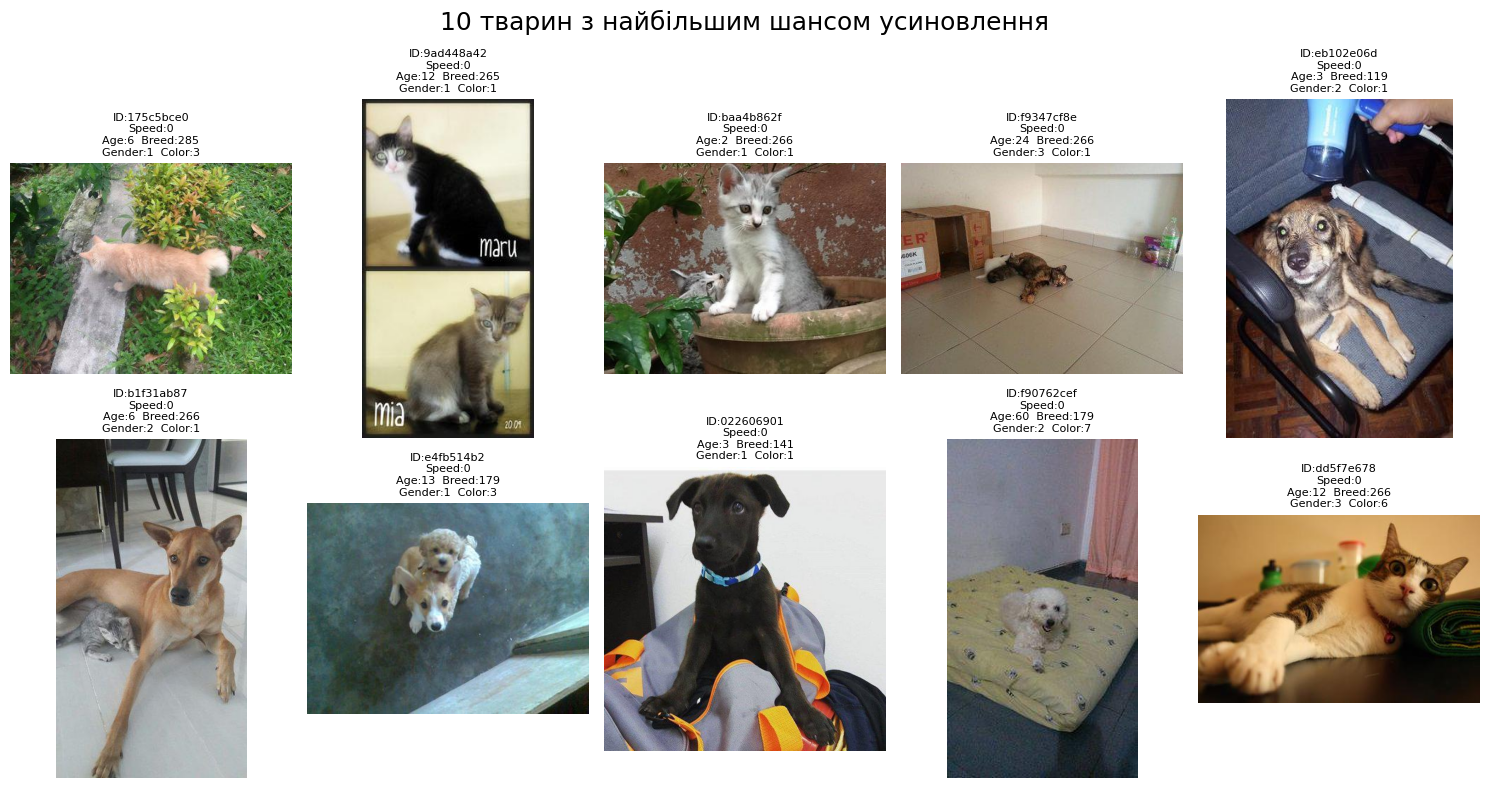

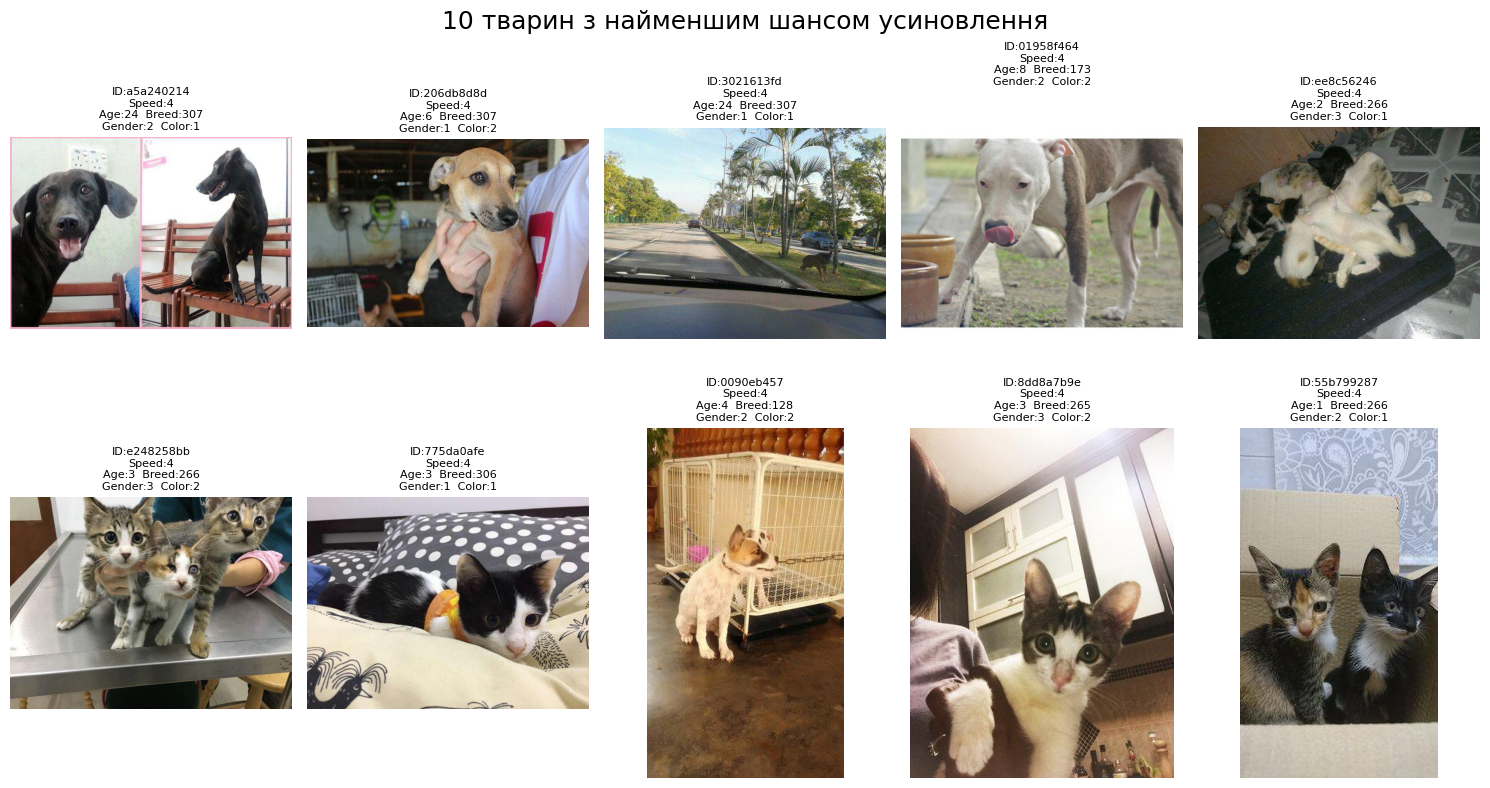

In [22]:
# Функція для відображення фото з параметрами
def show_pets_with_info(df, title):
    plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=18)

    for i, (_, row) in enumerate(df.iterrows()):
        pet_id = row["PetID"]
        img_path = f"/kaggle/input/petfinder-adoption-prediction/train_images/{pet_id}-1.jpg"

        plt.subplot(2, 5, i+1)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.imshow(img)
        else:
            plt.text(0.5, 0.5, "No image", ha='center', va='center')

        # Параметри
        info = (
            f"ID:{pet_id}\n"
            f"Speed:{row['AdoptionSpeed']}\n"
            f"Age:{row['Age']}  Breed:{row['Breed1']}\n"
            f"Gender:{row['Gender']}  Color:{row['Color1']}"
        )
        plt.title(info, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Сортуємо по AdoptionSpeed
fastest = train.sort_values(by="AdoptionSpeed", ascending=True).head(10)
slowest = train.sort_values(by="AdoptionSpeed", ascending=False).head(10)

# Відображаємо
show_pets_with_info(fastest, "10 тварин з найбільшим шансом усиновлення")
show_pets_with_info(slowest, "10 тварин з найменшим шансом усиновлення")


[I 2025-08-25 16:33:01,187] A new study created in memory with name: no-name-3db8f7b8-bb01-4de1-8c12-1b4ecfc4ec66


X_train_combined shape: (11994, 2067)
X_val_combined shape: (2999, 2067)
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8607865572335258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607865572335258
[LightGBM] [Warning] lambda_l2 is set=2.3881775504279505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3881775504279505
[LightGBM] [Warning] lambda_l1 is set=1.2063511713763115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2063511713763115
[LightGBM] [Warning] bagging_fraction is set=0.5986593413560878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5986593413560878
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[Ligh

[I 2025-08-25 16:35:22,314] Trial 0 finished with value: 0.30107654475804135 and parameters: {'learning_rate': 0.03632292996566999, 'num_leaves': 56, 'max_depth': 10, 'feature_fraction': 0.8607865572335258, 'bagging_fraction': 0.5986593413560878, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 1.2063511713763115, 'lambda_l2': 2.3881775504279505}. Best is trial 0 with value: 0.30107654475804135.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190362374616789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190362374616789
[LightGBM] [Warning] lambda_l2 is set=1.4180634108633772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4180634108633772
[LightGBM] [Warning] lambda_l1 is set=3.1880797991295813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1880797991295813
[LightGBM] [Warning] bagging_fraction is set=0.5030143344075539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5030143344075539
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190362374616789, colsample_byt

[I 2025-08-25 16:36:47,145] Trial 1 finished with value: 0.329008006269084 and parameters: {'learning_rate': 0.043861432749457425, 'num_leaves': 58, 'max_depth': 11, 'feature_fraction': 0.6190362374616789, 'bagging_fraction': 0.5030143344075539, 'bagging_freq': 5, 'min_child_samples': 32, 'lambda_l1': 3.1880797991295813, 'lambda_l2': 1.4180634108633772}. Best is trial 1 with value: 0.329008006269084.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7713392067329234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7713392067329234
[LightGBM] [Warning] lambda_l2 is set=3.4681167238048456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4681167238048456
[LightGBM] [Warning] lambda_l1 is set=0.6949201618368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6949201618368
[LightGBM] [Warning] bagging_fraction is set=0.779391161148376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.779391161148376
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7713392067329234, colsample_bytree=1.0 

[I 2025-08-25 16:37:36,900] Trial 2 finished with value: 0.3055745408695182 and parameters: {'learning_rate': 0.0923975775081612, 'num_leaves': 49, 'max_depth': 9, 'feature_fraction': 0.7713392067329234, 'bagging_fraction': 0.779391161148376, 'bagging_freq': 2, 'min_child_samples': 30, 'lambda_l1': 0.6949201618368, 'lambda_l2': 3.4681167238048456}. Best is trial 1 with value: 0.329008006269084.


[LightGBM] [Debug] Trained a tree with leaves = 49 and depth = 9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7713392067329234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7713392067329234
[LightGBM] [Warning] lambda_l2 is set=3.4681167238048456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4681167238048456
[LightGBM] [Warning] lambda_l1 is set=0.6949201618368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6949201618368
[LightGBM] [Warning] bagging_fraction is set=0.779391161148376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.779391161148376
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7804598674132233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804598674132233
[Ligh

[I 2025-08-25 16:39:44,729] Trial 3 finished with value: 0.3295435736364847 and parameters: {'learning_rate': 0.015622105428219787, 'num_leaves': 120, 'max_depth': 6, 'feature_fraction': 0.7804598674132233, 'bagging_fraction': 0.6456091278125141, 'bagging_freq': 3, 'min_child_samples': 62, 'lambda_l1': 2.595370333942309, 'lambda_l2': 2.81004247605843}. Best is trial 3 with value: 0.3295435736364847.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6647888367432003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647888367432003
[LightGBM] [Warning] lambda_l2 is set=2.125516959298163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.125516959298163
[LightGBM] [Warning] lambda_l1 is set=2.028879432794464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.028879432794464
[LightGBM] [Warning] bagging_fraction is set=0.7559990765312576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7559990765312576
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6647888367432003, colsample_bytree=

[I 2025-08-25 16:40:10,558] Trial 4 finished with value: 0.31474270249835523 and parameters: {'learning_rate': 0.08775108586147547, 'num_leaves': 27, 'max_depth': 4, 'feature_fraction': 0.6647888367432003, 'bagging_fraction': 0.7559990765312576, 'bagging_freq': 7, 'min_child_samples': 29, 'lambda_l1': 2.028879432794464, 'lambda_l2': 2.125516959298163}. Best is trial 3 with value: 0.3295435736364847.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6647888367432003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647888367432003
[LightGBM] [Warning] lambda_l2 is set=2.125516959298163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.125516959298163
[LightGBM] [Warning] lambda_l1 is set=2.028879432794464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.028879432794464
[LightGBM] [Warning] bagging_fraction is set=0.7559990765312576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7559990765312576
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6296620182891646, colsample_bytre

[I 2025-08-25 16:41:18,920] Trial 5 finished with value: 0.3241049366216303 and parameters: {'learning_rate': 0.04260559363247721, 'num_leaves': 24, 'max_depth': 6, 'feature_fraction': 0.6296620182891646, 'bagging_fraction': 0.7817886913519774, 'bagging_freq': 2, 'min_child_samples': 22, 'lambda_l1': 4.590905965259125, 'lambda_l2': 1.8642441533988308}. Best is trial 3 with value: 0.3295435736364847.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6759059415741522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759059415741522
[LightGBM] [Warning] lambda_l2 is set=2.4848336206629207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4848336206629207
[LightGBM] [Warning] lambda_l1 is set=0.8330948327047721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8330948327047721
[LightGBM] [Warning] bagging_fraction is set=0.7814574421900915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7814574421900915
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6759059415741522, colsample_byt

[I 2025-08-25 16:41:46,174] Trial 6 finished with value: 0.316245994908107 and parameters: {'learning_rate': 0.08079094759681905, 'num_leaves': 72, 'max_depth': 4, 'feature_fraction': 0.6759059415741522, 'bagging_fraction': 0.7814574421900915, 'bagging_freq': 6, 'min_child_samples': 36, 'lambda_l1': 0.8330948327047721, 'lambda_l2': 2.4848336206629207}. Best is trial 3 with value: 0.3295435736364847.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6592010197651657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6592010197651657
[LightGBM] [Warning] lambda_l2 is set=4.238041048311107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.238041048311107
[LightGBM] [Warning] lambda_l1 is set=4.228462172880357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.228462172880357
[LightGBM] [Warning] bagging_fraction is set=0.5802294599360801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5802294599360801
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6592010197651657, colsample_bytree=

[I 2025-08-25 16:42:46,690] Trial 7 finished with value: 0.3385626093828815 and parameters: {'learning_rate': 0.018637756971722163, 'num_leaves': 62, 'max_depth': 3, 'feature_fraction': 0.6592010197651657, 'bagging_fraction': 0.5802294599360801, 'bagging_freq': 3, 'min_child_samples': 36, 'lambda_l1': 4.228462172880357, 'lambda_l2': 4.238041048311107}. Best is trial 7 with value: 0.3385626093828815.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6592010197651657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6592010197651657
[LightGBM] [Warning] lambda_l2 is set=4.238041048311107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.238041048311107
[LightGBM] [Warning] lambda_l1 is set=4.228462172880357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.228462172880357
[LightGBM] [Warning] bagging_fraction is set=0.5802294599360801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5802294599360801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6652747315690148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6652747315690148
[LightGBM] [Warning] lambda_l2 is set=2.869970241888633, reg_lambd

[I 2025-08-25 16:43:35,515] Trial 8 finished with value: 0.3348571927729571 and parameters: {'learning_rate': 0.03632485141161316, 'num_leaves': 90, 'max_depth': 3, 'feature_fraction': 0.6652747315690148, 'bagging_fraction': 0.8355373213010484, 'bagging_freq': 1, 'min_child_samples': 27, 'lambda_l1': 3.3907721060758367, 'lambda_l2': 2.869970241888633}. Best is trial 7 with value: 0.3385626093828815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6652747315690148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6652747315690148
[LightGBM] [Warning] lambda_l2 is set=2.869970241888633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.869970241888633
[LightGBM] [Warning] lambda_l1 is set=3.3907721060758367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3907721060758367
[LightGBM] [Warning] bagging_fraction is set=0.8355373213010484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8355373213010484
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5903537315800791, colsample_bytr

[I 2025-08-25 16:44:01,469] Trial 9 finished with value: 0.31842260939321765 and parameters: {'learning_rate': 0.07201505587808593, 'num_leaves': 77, 'max_depth': 5, 'feature_fraction': 0.5903537315800791, 'bagging_fraction': 0.684905906224268, 'bagging_freq': 3, 'min_child_samples': 76, 'lambda_l1': 3.599548251860271, 'lambda_l2': 2.3385839383185747}. Best is trial 7 with value: 0.3385626093828815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5903537315800791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5903537315800791
[LightGBM] [Warning] lambda_l2 is set=2.3385839383185747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3385839383185747
[LightGBM] [Warning] lambda_l1 is set=3.599548251860271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599548251860271
[LightGBM] [Warning] bagging_fraction is set=0.684905906224268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684905906224268
Best params: {'learning_rate': 0.018637756971722

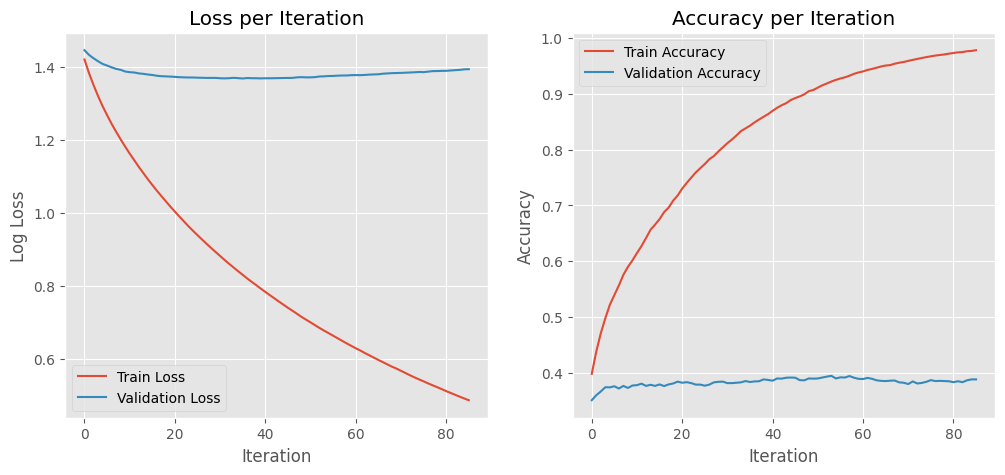

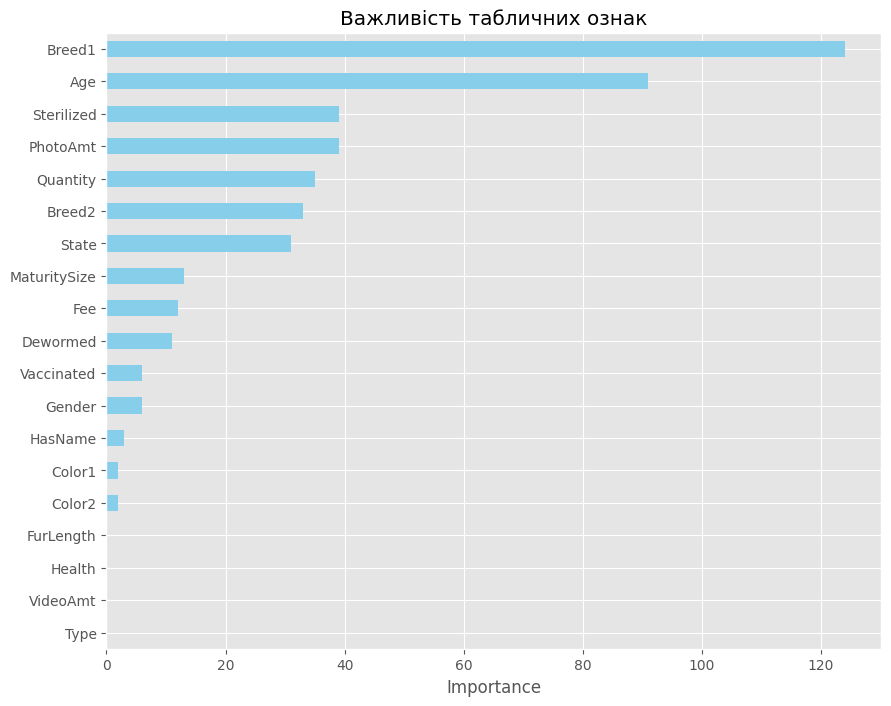

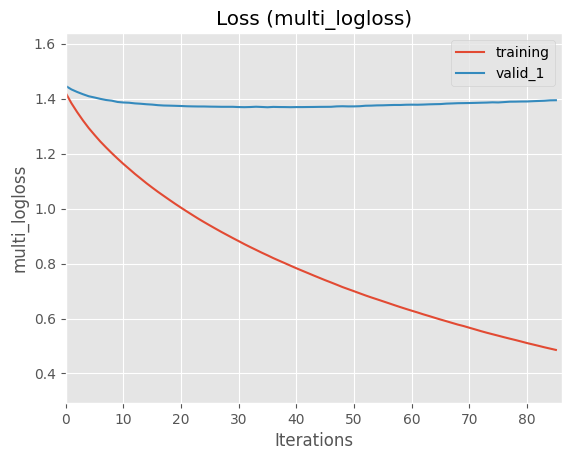

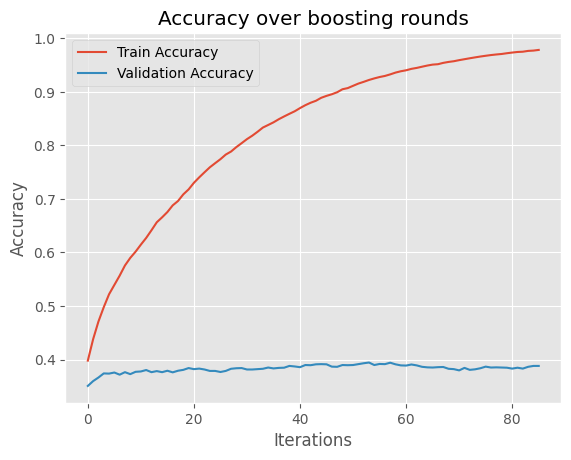

In [30]:
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import cohen_kappa_score, accuracy_score
import optuna

# ==============================
# 1. Табличні фічі
# ==============================



features = [
    'Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
    'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'HasName'
]

train_data = all_data[all_data['dataset_type'] == 'train']
X_tab = train_data[features]
y = train_data['AdoptionSpeed']  # без NaN

categorical_features = [
    'Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
    'Sterilized', 'Health', 'State', 'HasName'
]

# ==============================
# 2. Train/Validation Split
# ==============================
train_idx, val_idx = train_test_split(
    np.arange(len(X_tab)), test_size=0.2, random_state=42, stratify=y
)

X_tab_train = csr_matrix(X_tab.iloc[train_idx].values)
X_tab_val   = csr_matrix(X_tab.iloc[val_idx].values)

y_train = y.iloc[train_idx]
y_val   = y.iloc[val_idx]

# ==============================
# 3. ResNet features (ти вже їх маєш)
# ==============================
resnet_train_split = resnet_train_features[train_idx, :]
resnet_val_split   = resnet_train_features[val_idx, :]

resnet_train_sparse = csr_matrix(resnet_train_split)
resnet_val_sparse   = csr_matrix(resnet_val_split)

# ==============================
# 4. Поєднуємо табличні + ResNet
# ==============================
X_train_combined = hstack([X_tab_train, resnet_train_sparse])
X_val_combined   = hstack([X_tab_val, resnet_val_sparse])

print("X_train_combined shape:", X_train_combined.shape)
print("X_val_combined shape:", X_val_combined.shape)

# ==============================
# 5. Функція для Optuna
# ==============================
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 5,
        "metric": "multi_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 120),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.9),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 80),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "random_state": 42
    }

    model = lgb.LGBMClassifier(**params, n_estimators=1000)
    
    # Визначаємо індекси табличних фіч:
    cat_indices = [i for i, col in enumerate(features) if col in categorical_features]
    
    model.fit(
        X_train_combined, y_train,
        eval_set=[(X_val_combined, y_val)],
        eval_metric="multi_logloss",
        categorical_feature=cat_indices,
        callbacks=[lgb.early_stopping(stopping_rounds=5, verbose=False)]
    )

    y_pred = model.predict(X_val_combined)
    return quadratic_weighted_kappa(y_val, y_pred)

# ==============================
# 6. Запускаємо Optuna
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)
print("Best QWK:", study.best_value)

# ======================
# 3. Графіки
# ======================


# Графік метрик

evals_result = model.evals_result_
train_loss = evals_result['training']['multi_logloss']
val_loss = evals_result['valid_1']['multi_logloss']
train_acc = [1 - x for x in evals_result['training']['multi_error']]
val_acc = [1 - x for x in evals_result['valid_1']['multi_error']]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Loss per Iteration')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per Iteration')
plt.legend()

plt.show()

# Табличні ознаки
tab_features = features  # список з базових колонок без TF-IDF

importances = pd.Series(model.feature_importances_[:len(tab_features)], index=tab_features)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(10,8))
importances.plot(kind='barh', color='skyblue')
plt.title('Важливість табличних ознак')
plt.xlabel('Importance')
plt.show()

# Loss
lgb.plot_metric(evals_result, metric="multi_logloss")
plt.title("Loss (multi_logloss)")
plt.show()

# Accuracy (1 - multi_error)
train_acc = [1 - e for e in evals_result["training"]["multi_error"]]
val_acc = [1 - e for e in evals_result["valid_1"]["multi_error"]]

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over boosting rounds")
plt.show()



In [29]:
# ==============================


# Додаємо HasName як у train
submit["HasName"] = submit["Name"].apply(lambda x: 0 if pd.isna(x) else 1)

# Табличні ознаки
X_tab_test = csr_matrix(submit[features].values)

# ==============================
# 2. ResNet фічі для тесту
# ==============================
X_resnet_test = csr_matrix(resnet_test_features)

# ==============================
# 3. Об'єднуємо табличні + ResNet
# ==============================
X_test_combined = hstack([X_tab_test, X_resnet_test])

# ==============================
# 4. Передбачення
# ==============================
y_test_pred = model.predict(X_test_combined)

# ==============================
# 5. Створюємо submission
# ==============================
submission = pd.DataFrame({
    "PetID": submit["PetID"],
    "AdoptionSpeed": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print(submission.head(10))

# Перевірка розподілу класів
submission_counts = submission['AdoptionSpeed'].value_counts().reset_index()
submission_counts.columns = ['AdoptionSpeed', 'Count']
print(submission_counts)
print("✅ Submission збережено")

       PetID  AdoptionSpeed
0  e2dfc2935            4.0
1  f153b465f            2.0
2  3c90f3f54            1.0
3  e02abc8a3            4.0
4  09f0df7d1            4.0
5  0487529d4            2.0
6  bae7c4b1c            4.0
7  548bcf206            2.0
8  0f82cea1e            4.0
9  a3787f15e            4.0
   AdoptionSpeed  Count
0            4.0   1646
1            2.0   1247
2            1.0    687
3            3.0    390
4            0.0      2
✅ Submission збережено


In [ ]:
Summary:

Основні метрики при виборі тварини:
Найбільший вплив на швидкість адопції мають якість фото, вік та тип тварини.

Фактори, що знижують шанси знайти домівку:
- Негарне фото або фото, де тварина зображена з іншими тваринами.
- Неповно заповнені параметри (наприклад, не вказано стать чи породу).

Результати по метриках Quadratic Kappa:
- Без текстових ознак: 0.3684
- З текстовими ознаками: 0.3170
- Додавання текстових ознак погіршило якість прогнозу → текстові фічі могли містити шум або дублювати інформацію, що знижує стабільність моделі.

Результати після Optuna та налаштувань:
- Quadratic Kappa на validation піднявся до 0.3386
- Найкраща ітерація по early stopping: 36
- Training multi_logloss: 0.8299, multi_error: 0.157
- Validation multi_logloss: 1.3688, multi_error: 0.617

Показує, що модель все ще трохи перенавчається, але оптимізація гіперпараметрів та регуляризація зменшили дисбаланс train/val.

Аналіз перенавчання:
- Значна різниця між train_loss та val_loss свідчить про overfitting.
- Рекомендовано використовувати early stopping та регуляризацію, що й було зроблено: lambda_l1=4.23, lambda_l2=4.24, min_child_samples=36.

Важливість ознак:
- Найбільший вплив на модель: фото, вік, тип тварини.
- Додавання TF-IDF ознак не підвищило точність, що свідчить про шум у текстових даних.

Рекомендації щодо покращення:

- Зменшення overfitting: early stopping, регуляризація, обмеження глибини дерев (max_depth=3).
- Додаткові дані, що могли б покращити прогноз: розташування оголошення, частота додавання до “favorite”, поведінкові дані користувачів.

Висновки:

1. Модель правильно відслідковує основні фактори, що впливають на адопцію: якісне фото, вік та тип тварини.
2. Після оптимізації гіперпараметрів та early stopping модель стала більш стабільною і показує кращу генералізацію.
3. Люди "обирають очима" — фото залишаються головним чинником при виборі тварини.